# Overview of what we want to achieve:

* develop replacement model
* develop way to sample from the replacement model
* need to make a dataset and dataloader
* write the evaluation + calculate the accuracy
* need to put this as a Validation Metric to track in our training loop

## What are the different implementation options?

1. Combine gpt2 + CLT; use hooks
* we load gpt2 in memory
* we load (or have) the CLT in memory
* we use nnsight to put a lot of hooks into gpt2
* each hook runs part of the clt

2. write a replacement model class from scratch
* basically like a transformer but replace the MLPs with they weights from the clt
* read in attention weights, W_enc, W_pos, W_unemb from gpt2
* read in CLT weights from the CLT

### Things to consider for decision:
* easy to read and understand
* whether it's okay to ie during validation offload the CLT and gpt2 to load this model


### local replacement model
* run gpt2 on some prompts, store mlp_in, mlp_out
* run through the CLT model using activations from gpt2
* calculate the error terms recons - mlp_out

### What is the replacement model used for?
* just for evaluation

## Conclusion:

Since the replacement model will only be used as a validation metric and has no use cases downstream, the best option to implement this as a hook function model with nnsight because we won't need to load in weights, we can simply use the model

In [1]:
import os
# use cuda 0
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import torch
from einops import einsum
    

In [2]:
import nnsight

gpt2 = nnsight.LanguageModel('openai-community/gpt2', device_map='auto', dispatch=True)
gpt2.requires_grad_(False)

/var/local/glang/crosslayer-transcoder/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
  (generator): Generator(
    (streamer): Streamer()
  

In [3]:
from utils import get_webtext_dataloader

loader = get_webtext_dataloader(gpt2, batch_size=5)

In [298]:
from clt import CrossLayerTranscoder
from jumprelu import JumpReLU

clt = CrossLayerTranscoder.load_from_checkpoint('checkpoints/clt_model.ckpt')

In [299]:
from einops import rearrange


class ReplacementModel(torch.nn.Module):
    def __init__(self, gpt2, clt):
        super(ReplacementModel, self).__init__()
        self.gpt2 = gpt2
        self.clt = clt
        self.n_layers = self.gpt2.config.n_layer
        assert self.n_layers == self.clt.config['n_layers']
        self.n_features = self.clt.config['d_features']
        
    def handle_device(self, tokens):
        clt.to(gpt2.device)
        tokens = tokens.to(gpt2.device)
        return tokens

    def forward(self, tokens):
        tokens = self.handle_device(tokens)
        with self.gpt2.trace(tokens) as tracer:
            # features: batch_size x seq_len x n_layers x n_features
            features = torch.full((tokens.shape[0], tokens.shape[1], self.n_layers, self.n_features), float('nan'), device=tokens.device)

            mlp_ins = []
            mlp_outs = []
            resids_outs = []

            for layer in range(self.n_layers):
                mlp_in = self.gpt2.transformer.h[layer].ln_2.input.save()  # batch_size x seq_len x d_resid
                mlp_ins.append(mlp_in)
                # TODO: get features by running clt encoder on this layer
                mean = mlp_in.mean(dim=-1, keepdim=True)
                std = mlp_in.std(dim=-1, keepdim=True)
                mlp_in_norm = (mlp_in - mean) / std
                pre_actvs = einsum(mlp_in_norm, self.clt.W_enc[layer], 'batch seq d_acts, d_acts d_features -> batch seq d_features')
                feature_mask = torch.logical_and(pre_actvs > self.clt.jump_thresh[:, layer, :][None, ...], pre_actvs > 0.)
                post_actvs = pre_actvs * feature_mask
                features[..., layer, :] = post_actvs

                #f = features.save()
                recons_norm = einsum(features[..., :layer + 1, :], self.clt.W_dec[:layer + 1, layer], 'batch seq n_layers d_features, n_layers d_features d_acts -> batch seq d_acts')
                recons = recons_norm# * std + mean

                #r = recons.save()

                mlp_out = self.gpt2.transformer.h[layer].mlp.output.save()
                mlp_outs.append(mlp_out.save())
                resids_outs.append(recons.save())
                # TODO: get reconstructions by running clt decoder on features of all lower layers
                self.gpt2.transformer.h[layer].mlp.output = recons
                logits = self.gpt2.lm_head.output.save()
            features = features.save()
        
        mlp_outs = torch.stack(mlp_outs)  # n_layers x batch_size x seq_len x d_acts
        mlp_outs = rearrange(mlp_outs, 'n_layers batch_size seq_len d_acts -> (batch_size seq_len) n_layers d_acts')
        resids_outs = torch.stack(resids_outs)
        resids_outs = rearrange(resids_outs, 'n_layers batch_size seq_len d_acts -> (batch_size seq_len) n_layers d_acts')

        return logits, mlp_ins, mlp_outs, resids_outs, features

        
replacement_model = ReplacementModel(gpt2, clt)

# TODO:

1. Convert this to a Lightning Metric to track during training
2. Add L0_per_layer as a Lightning Metric
3. Think about normalization and fix that

### Issue with Normalization:

* I currently normalize inputs but the reconstructions need to approximate the real mlp output
* MLP output is much larger in later layers, so MSE is of course much higher
* this incentivizes the model to put all L0 into the last 2 layers, and just don't use all other layers
* What is a principled solution? Problem is that W_norm is also going into sparsity penalty so there's an issue as well with size
* best solution would be if standardized data goes in, and standardized data comes out
* but: what's the factor we standardize the output with? we can just use the mlp output but then we can't use it in our replacement model!!!
* idea: for the very first training batch, calculate mean and stdev for mlp inputs AND outputs separately, and save these as a buffer in the model. Then always scale all values by this. That way, I can also use it later 


Sidenote: should I exclude the e.g. 5 outlier dimensions when calculating stdev? That might actually be a hyperparameter to tune.

In [300]:
# iterate over batches
# get logits for gpt2
# get logits for replacement model
# calculate accuracy
with torch.no_grad():
    for batch in loader:
        bos = torch.full((batch.shape[0], 1), gpt2.config.bos_token_id, dtype=torch.long, device=batch.device)
        batch = torch.cat([bos, batch], dim=1)
        logits_gpt2 = gpt2(batch.to(gpt2.device))

        logits_replacement, mlp_ins, mlp_outs, resids_outs, features = replacement_model(batch)
        print(logits_gpt2.logits.shape)
        print(logits_replacement.shape)
        break

torch.Size([5, 1024, 50257])
torch.Size([5, 1024, 50257])


In [288]:
mse = ((mlp_outs - resids_outs) ** 2).mean()
mse

tensor(0.4748, device='cuda:0')

In [301]:
features.shape

torch.Size([5, 1024, 12, 6144])

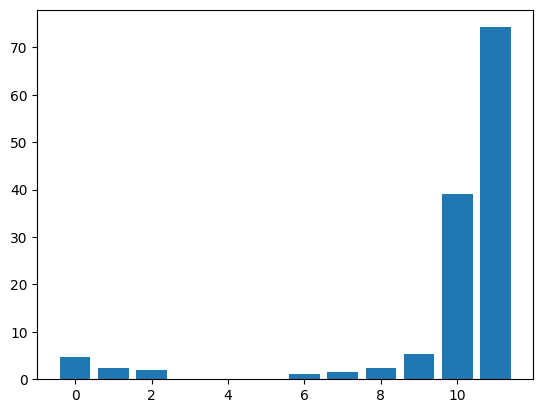

In [325]:
l0_per_layer = (features > 0.).float().sum(dim=(0, 1, 3)) / (features.shape[0] * features.shape[1])
plt.bar(range(len(l0_per_layer)), l0_per_layer.cpu().numpy())
plt.show()

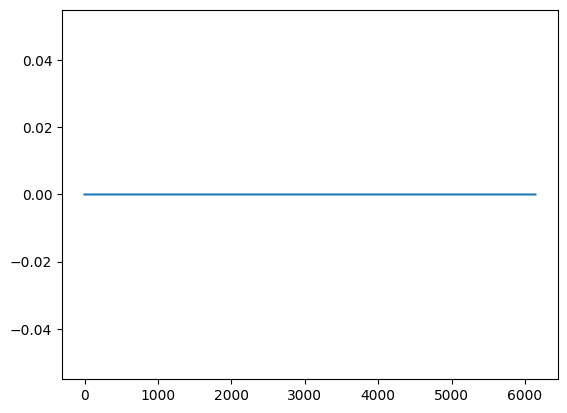

In [318]:
plt.plot(features[0, 30, 7].cpu().numpy())

In [215]:
mlp_outs.shape

torch.Size([5, 1024, 12, 768])

In [204]:
outs = torch.stack(mlp_outs)
outs = rearrange(outs, 'n_layers batch_size seq_len d_acts -> (batch_size seq_len) n_layers d_acts')
outs[0, 0].shape

torch.Size([768])

In [274]:
mlp_outs.shape

torch.Size([5, 1024, 12, 768])

(12, 200)


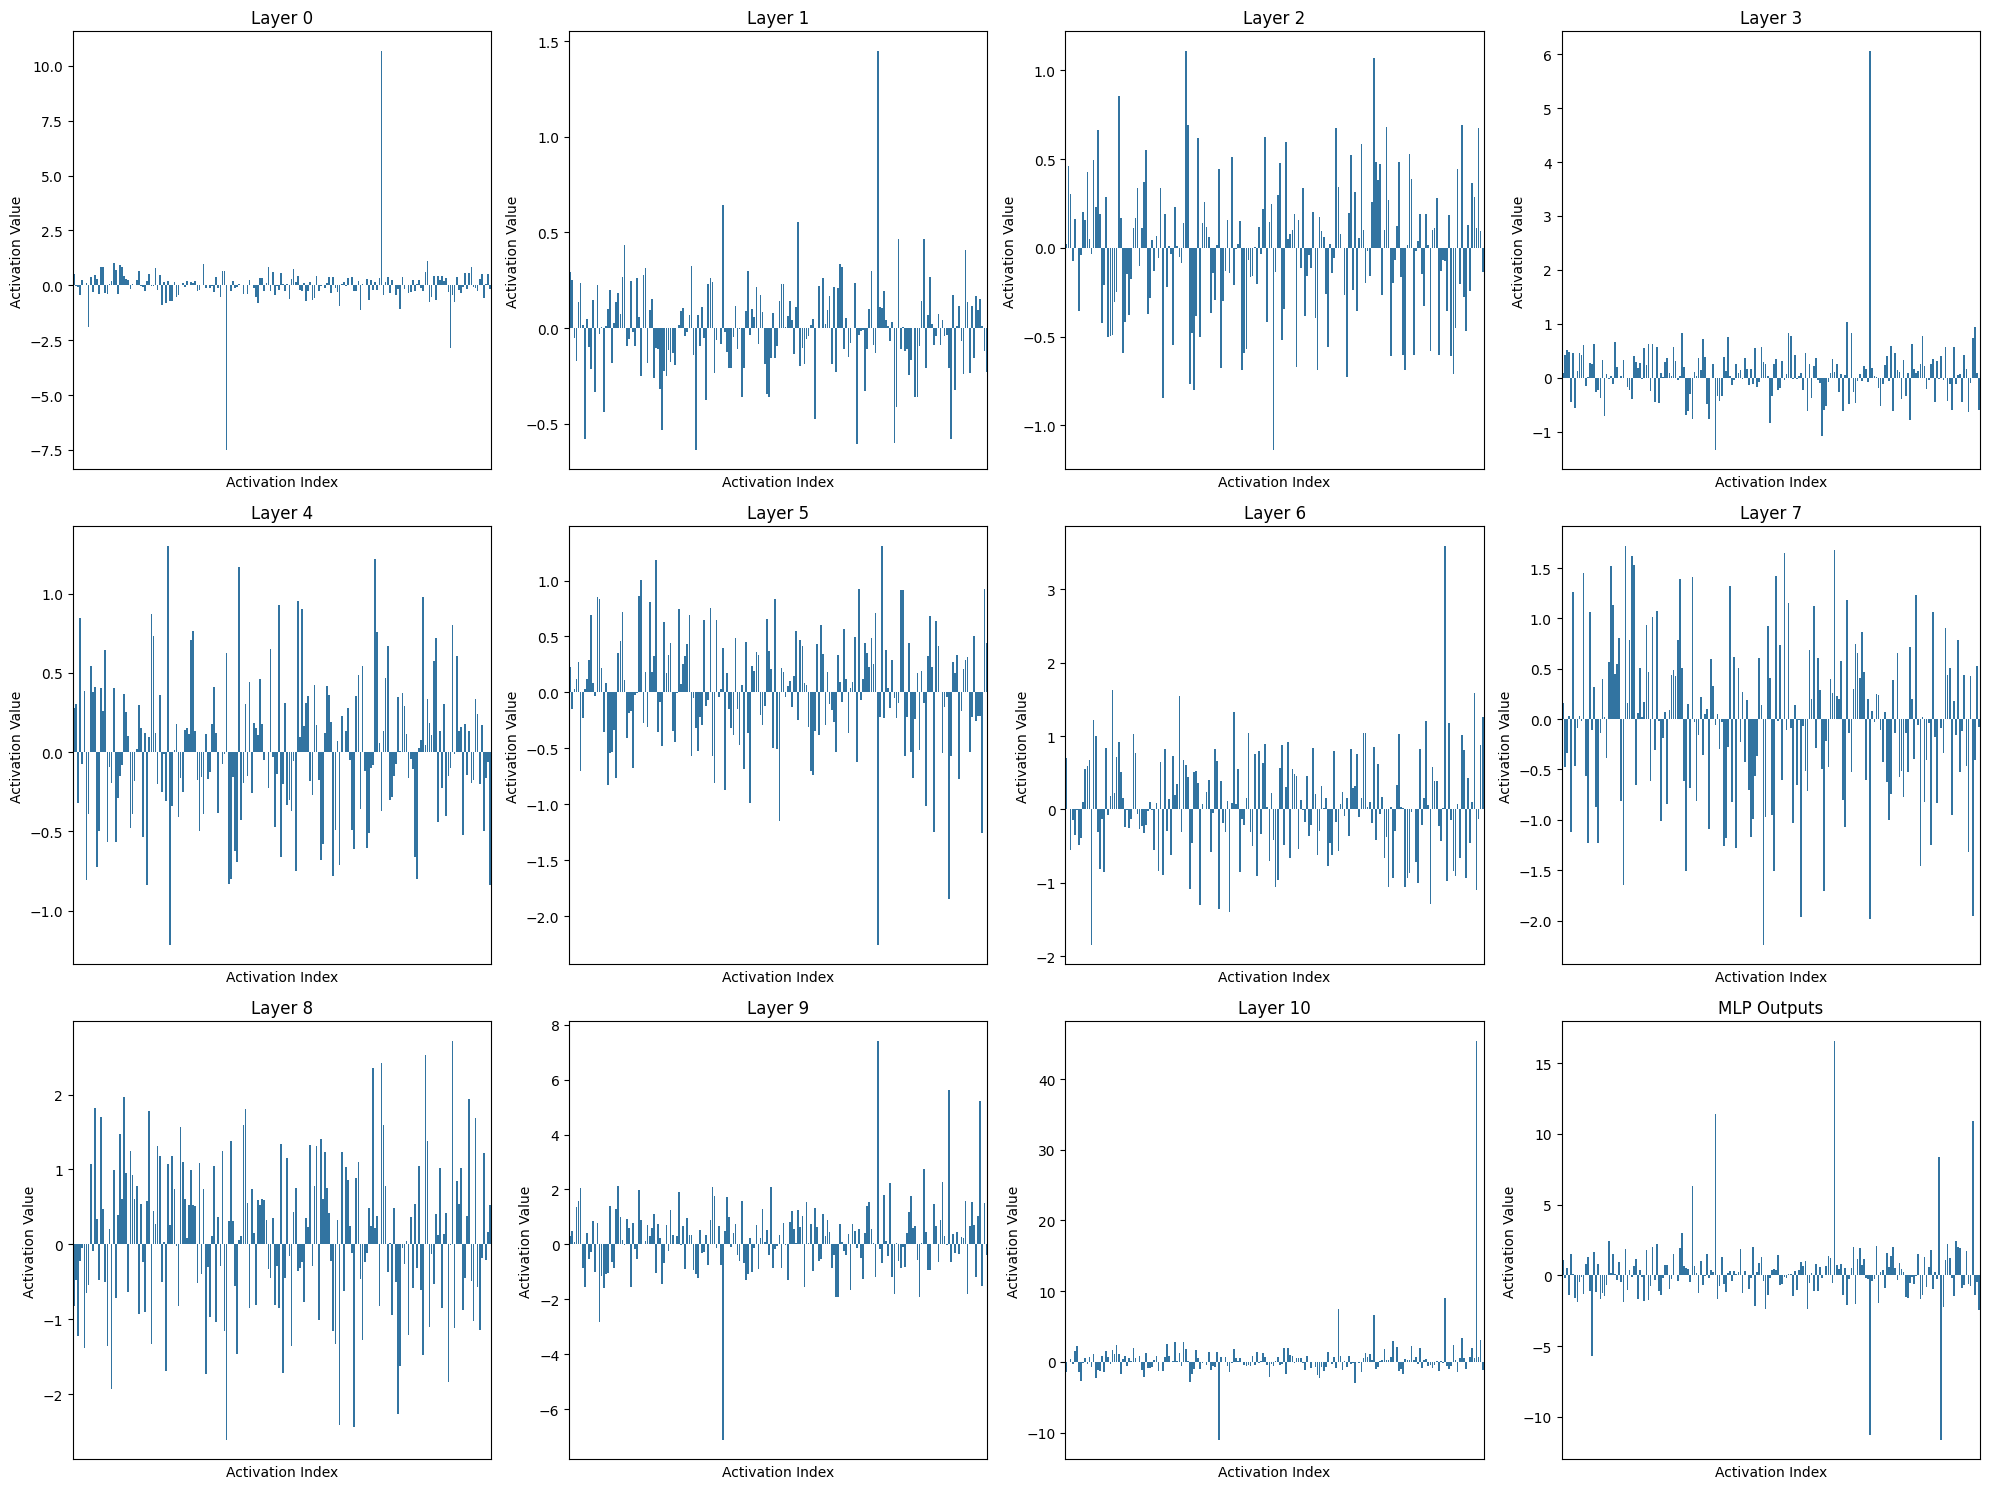

(12, 200)


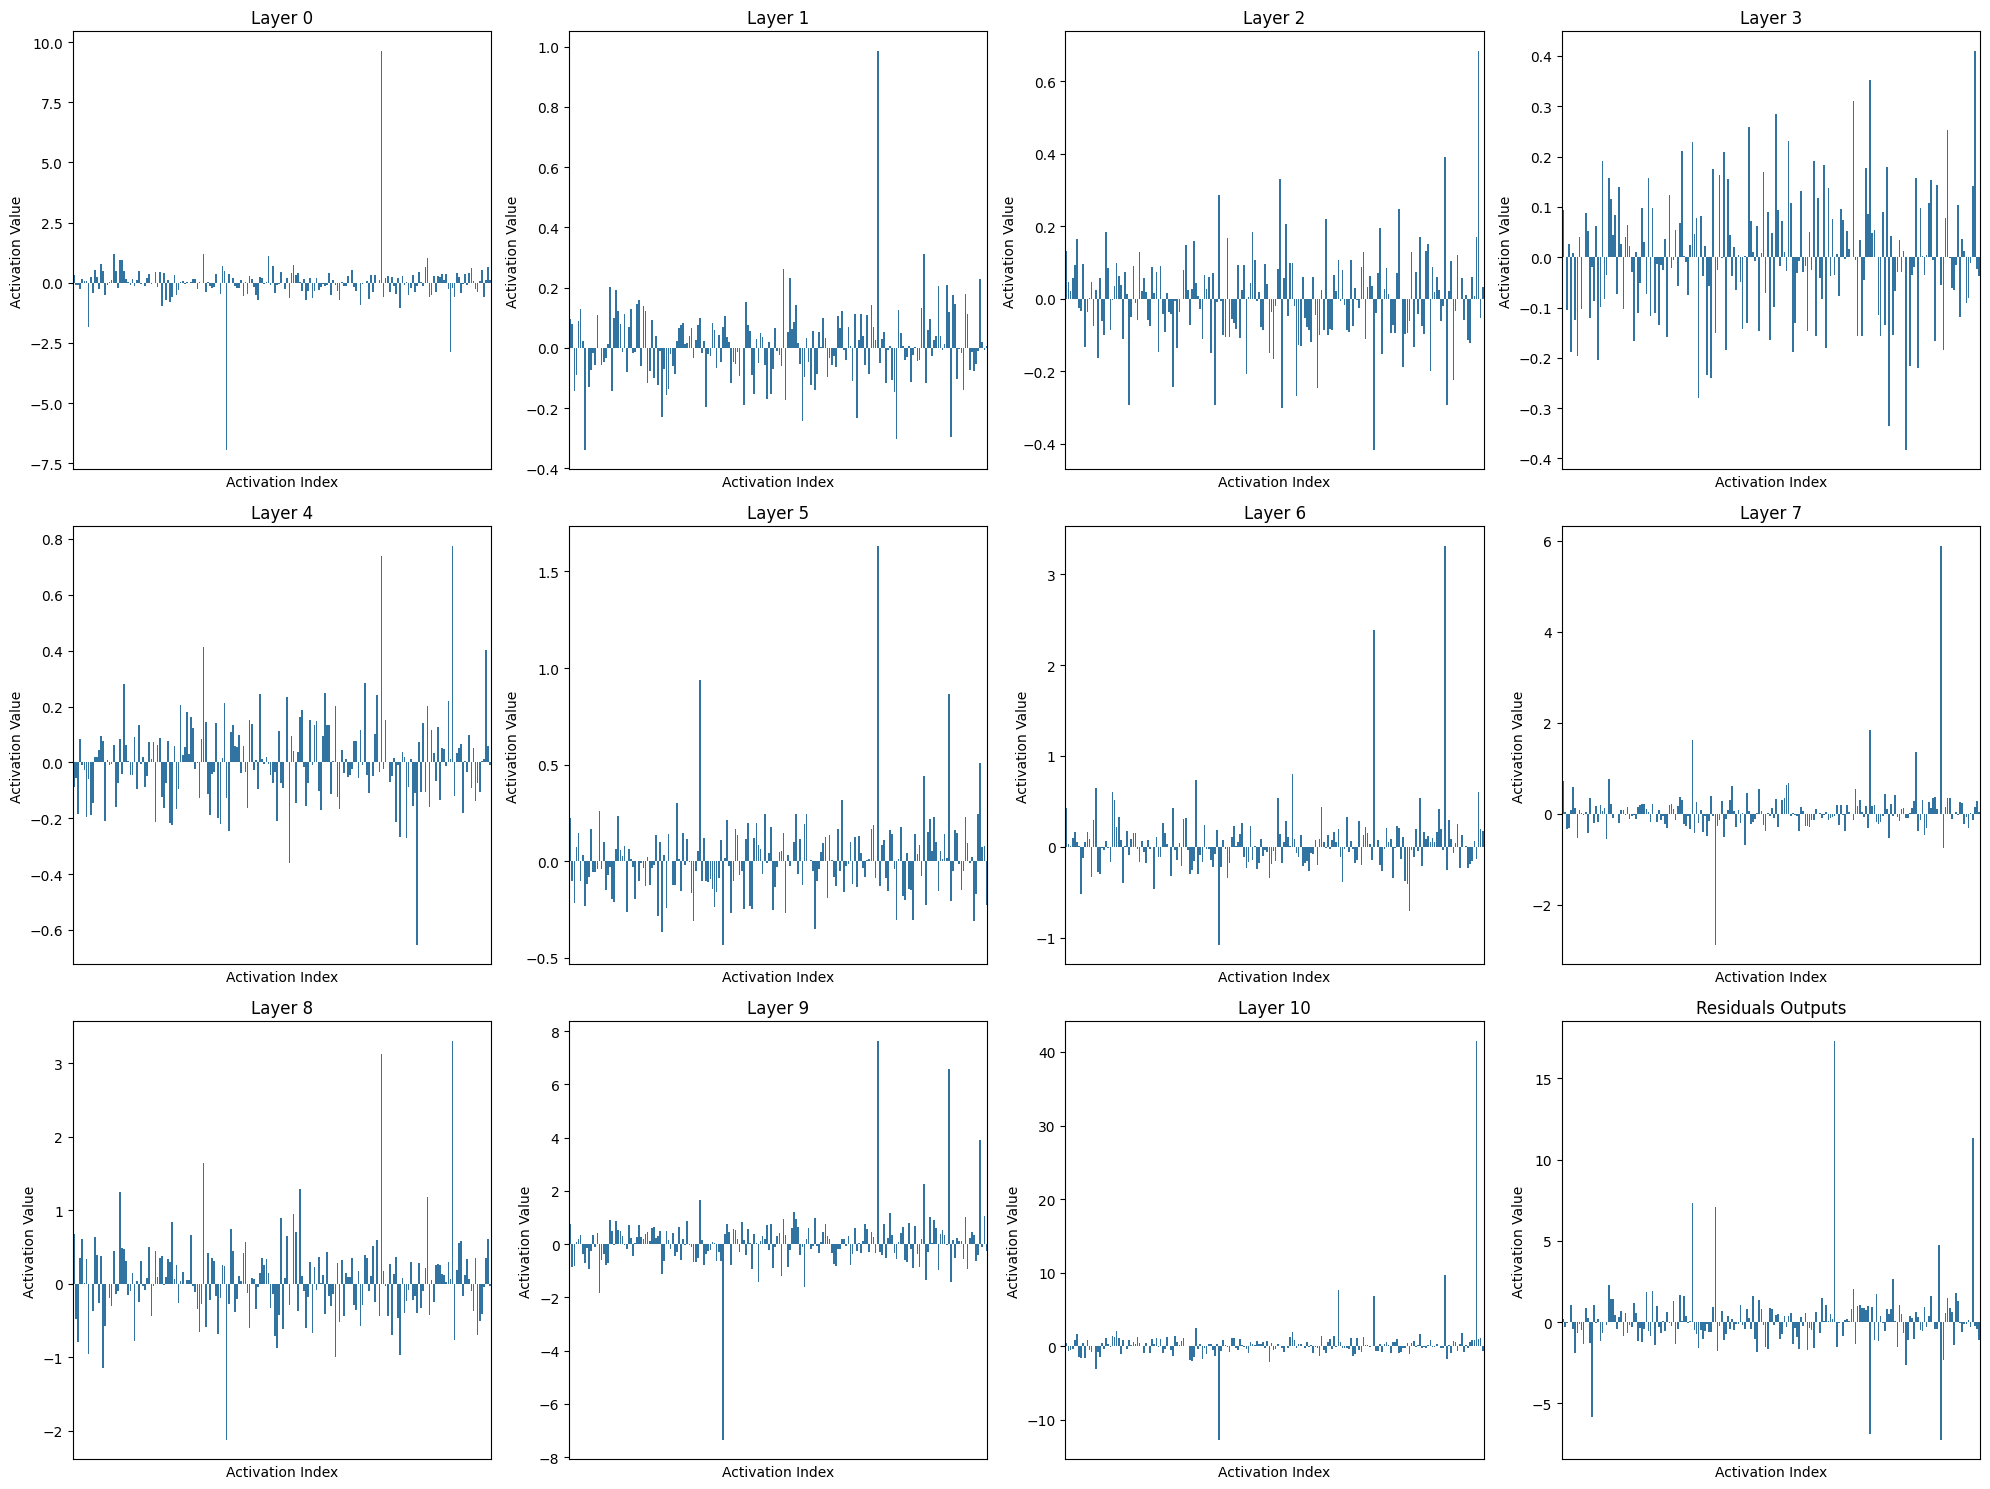

In [289]:
def plot_actvs(actvs):
    idx = 200
    if type(actvs) == list:
        # actvs: list(n_layers), every entry tensor batch_size x seq_len x d_acts
        actvs = torch.stack(
            [actv[0, idx, 300:500] for actv in actvs]
        )  # n_layers x d_acts
    else:  # batch_size x n_layers x d_acts
        actvs = actvs[idx, :, 300:500]  # n_layers x d_acts
    actvs = actvs.cpu().numpy()
    print(actvs.shape)

    import matplotlib.pyplot as plt
    import seaborn as sns

    # Create a 3x4 grid of subplots
    fig, axes = plt.subplots(3, 4, figsize=(20, 15))
    axes = axes.flatten()

    # Plot bar plots for each layer's activations
    for layer in range(actvs.shape[0]):
        actv = actvs[layer]
        sns.barplot(x=range(len(actv)), y=actv, ax=axes[layer])
        axes[layer].set_title(f"Layer {layer}")
        axes[layer].set_xlabel("Activation Index")
        axes[layer].set_ylabel("Activation Value")
        # remove xticks
        axes[layer].set_xticks([])

    # Adjust layout to prevent overlap
    plt.tight_layout()
plot_actvs(mlp_outs)
import matplotlib.pyplot as plt
plt.title("MLP Outputs")
plt.show()
plot_actvs(resids_outs)
plt.title("Residuals Outputs")
plt.show()

In [290]:
print("input string", gpt2.tokenizer.decode(batch[0])[:150])   
print("gpt2 logits", gpt2.tokenizer.decode(logits_gpt2.logits.argmax(dim=-1)[0])[:150])
print("replacement logits", replacement_model.gpt2.tokenizer.decode(logits_replacement.argmax(dim=-1)[0])[:150])




input string <|endoftext|>, RB, Jaguars: He reminds me of Le'Veon Bell, and right now, he might be a better version. Fournette's been an instrumental part of the J
gpt2 logits 

, RB, The's me of the'Veon Bell. who I now, he's be the better fit of
acingette is been a absolute part of the Jaguarsags' offense offense, and the 
replacement logits .

 and,
 is to to the- "... the the right. I is be the great..
.s, coach a great. of the Jaguars.. team.. and the.. the.. the of.for) a))
 the instru


In [291]:
print(logits_gpt2.logits[:1])

tensor([[[ -43.4316,  -39.8364,  -43.0659,  ...,  -54.0877,  -54.3451,
           -42.3644],
         [ -82.5248,  -82.2037,  -80.5324,  ...,  -89.2012,  -85.7544,
           -79.2723],
         [ -71.1275,  -70.7646,  -70.9003,  ...,  -80.3959,  -79.1892,
           -70.9391],
         ...,
         [-240.1608, -236.3308, -237.6885,  ..., -255.5307, -255.9310,
          -239.4240],
         [-245.1337, -239.5425, -241.1211,  ..., -260.0600, -266.1075,
          -245.3769],
         [ -63.7794,  -66.1090,  -66.9182,  ...,  -75.3384,  -73.5461,
           -64.0250]]], device='cuda:0')


In [292]:
logits_gpt2.logits.argmax(dim=-1)

tensor([[  198,   198,    11,  ...,    14,  1157,    13],
        [  198,   464,   464,  ..., 34553,    12,   938],
        [  198,  6153,    11,  ...,   352,    11,   318],
        [  198,   257,   262,  ...,   286,   257,    13],
        [  198,   318,  5813,  ...,  1664,    13,   198]], device='cuda:0')

In [293]:
logits_replacement.argmax(dim=-1)

tensor([[   13,   198,   198,  ...,   400,  1157, 20303],
        [   13,   198,   198,  ...,   820,    12,    13],
        [   13,   614,    11,  ...,    11,    11,   290],
        [   13,   257,  1871,  ...,   286,   262,   326],
        [   13,   318,   504,  ...,    11,    11,   198]], device='cuda:0')

In [294]:
gpt2.tokenizer.decode([15755])

' millenn'

In [295]:
(logits_gpt2.logits.argmax(dim=-1) == logits_replacement.argmax(dim=-1)).float().mean()

tensor(0.3187, device='cuda:0')

In [161]:
(logits_gpt2.logits.argmax(dim=-1)[:, :-1] == batch[:, 1:].cuda()).float().mean()

tensor(0.3881, device='cuda:0')

In [77]:
logits_gpt2.logits.shape

torch.Size([5, 1024, 50257])

In [79]:
batch.shape

torch.Size([5, 1024])

In [ ]:
del batch
del bos
torch.cuda.empty_cache()

In [40]:
clt.W_enc.device

device(type='cuda', index=0)

In [136]:
for batch in loader:
    bos = torch.zeros((batch.shape[0], 1), dtype=torch.long, device=batch.device) + gpt2.config.bos_token_id
    batch = torch.cat([bos, batch], dim=1)
    batch = batch.to('cuda:0')
    output = gpt2(batch)
    logits_orig = output.logits

    with gpt2.trace(batch) as tracer:
        mlp_ins = []
        mlp_outs = []
        for i in range(12):
            mlp_in = gpt2.transformer.h[i].ln_2.input.save()
            mlp_ins.append(mlp_in)
            mlp_out = gpt2.transformer.h[i].mlp.output.save()
            mlp_outs.append(mlp_out)
        logits_corrupted = gpt2.lm_head.output.save()
    print(mlp_in.shape)

    break

torch.Size([5, 1024, 768])


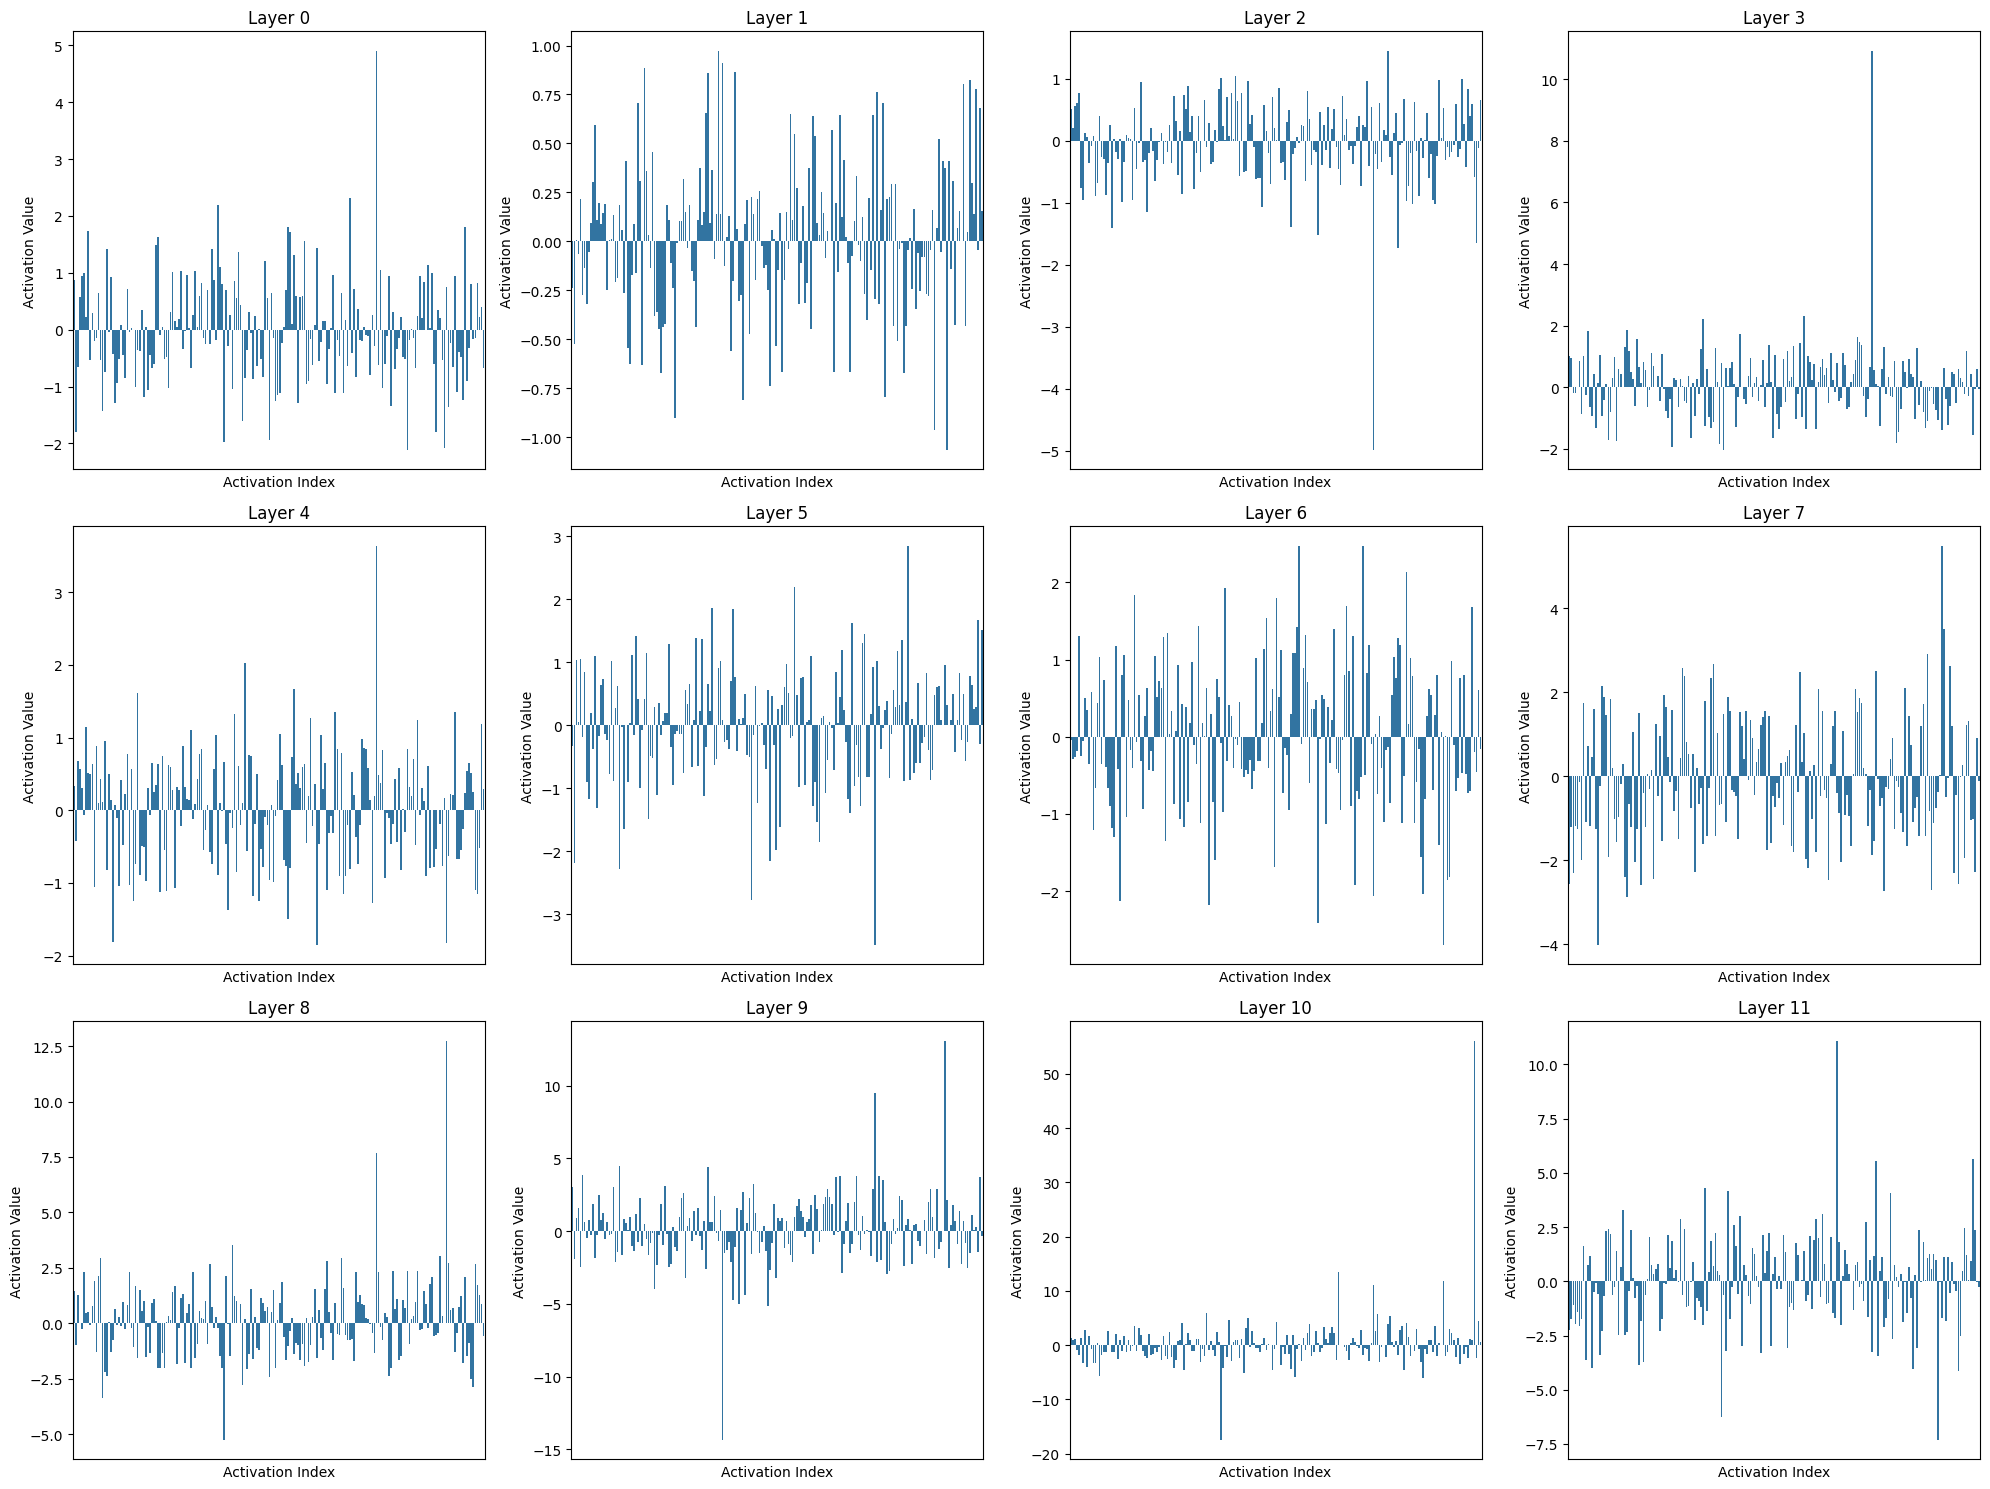

In [137]:

plot_actvs(mlp_outs)

In [6]:
for batch in loader:
    bos = torch.zeros((batch.shape[0], 1), dtype=torch.long, device=batch.device) + gpt2.config.bos_token_id
    batch = torch.cat([bos, batch], dim=1)
    batch = batch.to('cuda:0')
    batch = batch[:5]
    output = gpt2(batch)
    logits_orig = output.logits

    with gpt2.trace(batch) as tracer:
        mlp_ins = []
        mlp_outs = []
        for i in range(12):
            mlp_in = gpt2.transformer.h[i].ln_2.input.save()
            mlp_ins.append(mlp_in)
        mlp_ins = torch.stack(mlp_ins)
        mlp_ins *= 2.
        for i in range(12):
            mlp_out = gpt2.transformer.h[i].mlp.output.save()
            gpt2.transformer.h[i].mlp.output = mlp_ins[11 - i]
            mlp_outs.append(mlp_out)
        logits_corrupted = gpt2.lm_head.output.save()
    print(mlp_in.shape)

    break

torch.Size([5, 1024, 768])


In [10]:
for batch in loader:
    bos = torch.zeros((batch.shape[0], 1), dtype=torch.long, device=batch.device) + gpt2.config.bos_token_id
    batch = torch.cat([bos, batch], dim=1)
    batch = batch.to('cuda:0')
    batch = batch[:5]
    output = gpt2(batch)
    logits_orig = output.logits

    with gpt2.trace(batch) as tracer:
        mlp_out_8 = gpt2.transformer.h[8].mlp.output.save()
        mlp_out_2 = gpt2.transformer.h[2].mlp.output.save()
        gpt2.transformer.h[2].mlp.output = mlp_out_8
        mlp_out_2_corrupted = gpt2.transformer.h[2].mlp.output.save()
        #logits_corrupted = gpt2.lm_head.output.save()
    
    print('mlp_in_8', mlp_in_8)
    print('mlp_out_2', mlp_out_2)
    print('mlp_out_2_corrupted', mlp_out_2_corrupted)

    break

mlp_in_8 tensor([[[-0.2317, -0.1742,  0.4076,  ...,  1.2094,  0.9779,  0.3468],
         [ 0.0132,  5.9815, -1.3030,  ..., -2.3134,  3.5621,  0.9069],
         [-1.1271,  2.6131,  3.5580,  ..., -1.8958,  5.2259,  2.8670],
         ...,
         [ 0.4287, -0.4732,  0.4213,  ...,  0.6913,  1.9424,  2.2117],
         [-1.4544,  1.4217, -3.0940,  ...,  1.3569,  2.2228,  1.6743],
         [-2.6305, -1.8654, -0.4224,  ..., -0.9321, -2.3973, -0.3056]],

        [[-0.2317, -0.1742,  0.4076,  ...,  1.2094,  0.9779,  0.3468],
         [-0.7623,  1.7911,  0.1114,  ...,  0.8085, -2.6471,  0.6905],
         [ 0.3247,  0.2966, -0.4103,  ...,  0.7561, -1.7757, -0.6157],
         ...,
         [ 1.3467,  2.2840, -1.1671,  ...,  1.5021,  2.0084,  0.2160],
         [ 4.6676, -0.1384,  1.7488,  ...,  5.2829, -0.7914, -0.9944],
         [ 1.6990, -0.5843,  2.4302,  ...,  5.1885,  1.4176,  0.1654]],

        [[-0.2317, -0.1742,  0.4076,  ...,  1.2094,  0.9779,  0.3468],
         [-0.9271,  1.1020, -1.0148,

In [9]:
for batch in loader:
    bos = torch.zeros((batch.shape[0], 1), dtype=torch.long, device=batch.device) + gpt2.config.bos_token_id
    batch = torch.cat([bos, batch], dim=1)
    batch = batch.to('cuda:0')
    batch = batch[:5]
    output = gpt2(batch)
    logits_orig = output.logits

    with gpt2.trace(batch) as tracer:
        mlp_in_2 = gpt2.transformer.h[2].ln_2.input.save()
        mlp_out_8 = gpt2.transformer.h[8].mlp.output.save()
        gpt2.transformer.h[8].mlp.output = mlp_in_2
        mlp_out_8_corrupted = gpt2.transformer.h[8].mlp.output.save()
        #logits_corrupted = gpt2.lm_head.output.save()
    
    print('mlp_in_2', mlp_in_2)
    print('mlp_out_8', mlp_out_8)
    print('mlp_out_8_corrupted', mlp_out_8_corrupted)

    break

mlp_in_2 tensor([[[ 1.4882e-01, -7.8068e-02,  5.4677e-01,  ...,  1.6689e+00,
           1.4880e+00,  7.6614e-01],
         [ 1.7404e-01,  3.6589e+00, -1.4495e+00,  ..., -8.9506e-01,
          -1.6451e+00, -5.5786e-01],
         [-2.1732e+00, -3.9464e-01,  3.1175e+00,  ..., -8.9543e-01,
           3.3316e-01, -1.9379e+00],
         ...,
         [-3.6008e+00,  7.6212e-02, -2.9871e-01,  ..., -5.6556e-02,
          -1.4686e+00, -2.8403e-01],
         [ 6.0625e-01,  6.7959e-01,  4.2723e-01,  ..., -1.7862e-01,
           4.7519e-01,  1.1427e+00],
         [-3.5875e+00,  1.3844e+00,  2.0117e-03,  ...,  3.8480e-01,
           2.0642e+00,  3.3392e-01]],

        [[ 1.4882e-01, -7.8068e-02,  5.4677e-01,  ...,  1.6689e+00,
           1.4880e+00,  7.6614e-01],
         [-9.0029e-01, -4.9958e-01, -9.2506e-01,  ..., -1.5241e+00,
          -3.2433e-01, -7.3334e-01],
         [ 1.7569e+00, -6.3580e-02,  1.4569e-01,  ..., -8.2524e-01,
           6.4750e-01, -8.1157e-01],
         ...,
         [ 1.568